In [1]:
import tensorflow as tf
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras import *
from keras.src.layers import Dense, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [2]:
# If we want to use the models later, need to all have the same version of tensorflow and keras
print(tf.__version__)
print(keras.__version__)

2.18.0
3.6.0


### For data from Google Drive in Colab

In [ ]:
# Connect to drive in Colab
drive.mount('/content/drive/')

In [ ]:
# This unzips the zip in the drive. Addresses depend a little on how your drive is structured
data_compressed = '/content/drive/MyDrive/ ' #insert your drive path to zip here

zip_ref = zipfile.ZipFile(data_compressed,"r")
zip_ref.extractall('content/  ') # Address to folder where the images are extracted for the moment
zip_ref.close()

data_dir = 'content/ '# Address to folder that holds the two folder of good and not-good

image_size = (512,512)

train_data, val_data = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="both",
    seed=135,
    color_mode="rgb",
    image_size=image_size,
    crop_to_aspect_ratio=True # Cropping instead of morphing to keep more detail
)

### For data from local disk:

In [ ]:
data_dir = '' # Path to the folder that has good and bad images

image_size = (512,512)

train_data, val_data = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="both",
    seed=13,
    color_mode="rgb",
    image_size=image_size,
    shuffle=True,
)

Found 1034 files belonging to 2 classes.
Using 828 files for training.
Using 206 files for validation.


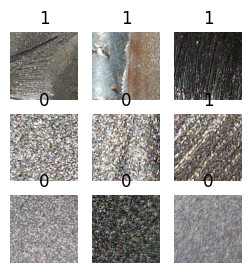

In [7]:
# Printing the images
plt.figure(figsize=(3, 3))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
# Need to normalise the datat
def normalize_data(data, label):
    data = tf.cast(data, tf.float32) / 255.0
    return data, label

train_data = train_data.map(normalize_data)
val_data = val_data.map(normalize_data)

In [9]:
# Feel free to change the model up
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(512, 512, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy']) # Could change this to recall

print(model.summary())

c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 256)  │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,350,273 (241.66 MB)

 Trainable params: 63,350,273 (241.66 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# BEFORE RUNNING THIS:
    # CHANGE THE NAME OF THE FILE BEFORE TRAINING, and keep track of which model is what ()


epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("Surface_Roughness_Cropped4_Dropout0.2_L-Data_512_E{epoch}.keras"), # change the name of the file
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',     # Monitor validation accuracy
        patience=3,                 # Stop after 3 epochs of no improvement
        restore_best_weights=True   # Restore the best weights
    )
]

history = model.fit(
    train_data,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data,
)

Epoch 1/20
10/26 ━━━━━━━━━━━━━━━━━━━━ 2:13 8s/step - accuracy: 0.4894 - loss: 4.8952

KeyboardInterrupt: 

In [ ]:
# Change current description to something that describes the model, so we can tell it apart
current_description = ''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss ' + current_description)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# plt.ylim(0, 0.6)
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy ' + current_description)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim(0, 1)
plt.show()